# Estimating $\pi$ using Quantum Phase Estimation and hybrid classical-quantum learning

This work is an extension of the [Piday notebook](https://github.com/Qiskit/platypus/blob/e7c70a13a0e7eec2d54e2b0bb78d1d67de816e18/notebooks/v2/ch-demos/piday-code.ipynb?short_path=cee2b44)

## 1. Quick overview of the Quantum Phase Estimation Algorithm

[Quantum Phase Estimation](/course/ch-algorithms/quantum-phase-estimation) (QPE) is a quantum algorithm that forms the building block of many more complex quantum algorithms. At its core, QPE solves a fairly straightforward problem: given an operator $U$ and a quantum state $\vert\psi\rangle$ that is an eigenvalue of $U$ with $U\vert\psi\rangle = \exp\left(2 \pi i  \theta\right)\vert\psi\rangle$, can we obtain an estimate of $\theta$?

The answer is yes. The QPE algorithm gives us $2^n\theta$, where $n$ is the number of qubits we use to estimate the phase $\theta$.

## 2. Estimating $\pi$

In this demo, we choose
$$U =  p(\theta), \vert\psi\rangle = \vert1\rangle$$
where 
$$
p(\theta) = \begin{bmatrix}
1 & 0\\ 0 & \exp(i\theta)
\end{bmatrix}
$$
is one of the quantum gates available in Qiskit, and
$$p(\theta)\vert1\rangle = \exp(i\theta)\vert1\rangle.$$ 

 By choosing the phase for our gate to be $\theta =  1$, we can solve for $\pi$ using the following two relations:

1. From the output of the QPE  algorithm, we measure an estimate for $2^n\theta$. Then, $\theta = \text{measured} / 2^n$ 
2. From the definition of the $p(\theta)$ gate above, we know that $2\pi\theta = 1 \Rightarrow \pi = 1 / 2\theta$

Combining these two relations, $\pi = 1 / \left(2 \times (\text{(measured)}/2^n)\right)$. 

For detailed understanding of the QPE algorithm, please refer to the chapter dedicated to it in the Qiskit Textbook located at [qiskit.org/textbook](/course/ch-algorithms/quantum-phase-estimation).

Unfortunately, the QPE algorithm requires prior knowledge of $\pi$. This means that, in order to estimate $\pi$ using QPE, we must first know the value of $\pi$. Catch 22! However, this problem can be solved using an application of classical-quantum learning: Let $f:\Re\mapsto\Re$ be a function that takes as input a guess, or candidate value, of $\pi$, and returns an estimate of $\pi$ using the steps 1-2 above, where $\pi$ in the QPE algorithm is replaced with the candidate value. We know that, as the number of qubits gets infinitely large, we will have $f(\pi) = \pi$. The idea is then, for a finite number of qubits, solve the fix point equation $f(x) - x = 0$. The fixed point equation can be solved classically using secant search, iteratively improving the estimate of $\pi$.

In [1]:
import operator
from  qiskit import *
from numpy import abs
from qiskit.primitives import Sampler

Initialization of the target qubit, and QFT on the measurement qubits:

In [2]:
def initialize_qubits(qc, measurement_qubits, target_qubit):
    qc.h(measurement_qubits)
    qc.x(target_qubit)

"Improper" QFT inverse using a candidate for $\pi$:

In [3]:
def apply_improper_iqft(qc, measurement_qubits, n):
    def f(pi_est):
        for target_qubit in measurement_qubits:
            for control_qubit in range(target_qubit):
                k = control_qubit - target_qubit - 1
                exponent = -2**(k)
                qc.cp(2*pi_est*exponent, control_qubit, target_qubit)
            qc.h(target_qubit)
            qc.barrier()
    return f

Function to create the circuit based on a candidate value for $\pi$:

In [4]:
def qpe_program(n, pi_est):
    # Create a quantum circuit on n+1 qubits (n measurement, 1 target)
    qc = QuantumCircuit(n+1, n)

    # Initialize the qubits
    initialize_qubits(qc, range(n), n)

    # Apply the controlled unitary operators in sequence
    for x in range(n):
        qc.cp(2**(n-x-1), x, n)

    qc.barrier()
    # Apply the "improper inverse quantum Fourier transform"
    apply_improper_iqft(qc, range(n), n)(pi_est)

    # Measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

Run the circuit, measure and return the $\pi$-candidate:

In [5]:
def measure_pi(n_qubits, qc, sampler, n_shots):
    def f(param):
        job = sampler.run(qc, param)
        #print(f">>> Job ID: {job.job_id()}")
        #print(f">>> Job Status: {job.status()}")
        result = job.result()
        probs = result.quasi_dists[0]
        highest_probability_outcome = max(probs.items(), key=operator.itemgetter(1))[0]
        return 2**(n_qubits-1) / int(highest_probability_outcome)
    return f

Implements secant search starting from two given guesses:

In [6]:
def estimate_pi(n_qubits, first_guess, second_guess, n_shots, sampler, max_iter):
    pi_est = first_guess
    pi = Parameter('pi')
    qcp = qpe_program(n_qubits, pi)
    measure = measure_pi(n_qubits, qcp, sampler, n_shots)
    measured = measure([pi_est])

    pi_est_last = second_guess
    measured_last = measure([pi_est_last])
    for k in range(max_iter):
        tmp = pi_est
        delta = measured - pi_est - measured_last + pi_est_last
        converged = abs(delta) < 1e-16
        if converged:
            print("using ", n_qubits, " qubits, converged after ", k, " iterations")
            return pi_est, measured
        else:
            pi_est = pi_est - (pi_est - pi_est_last) / delta * (measured - pi_est)
            measured_last = measured
            pi_est_last = tmp
            measured = measure([pi_est])
    print("failed to converge")
    return pi_est, measured

Draw the circuit for 4 qubits:

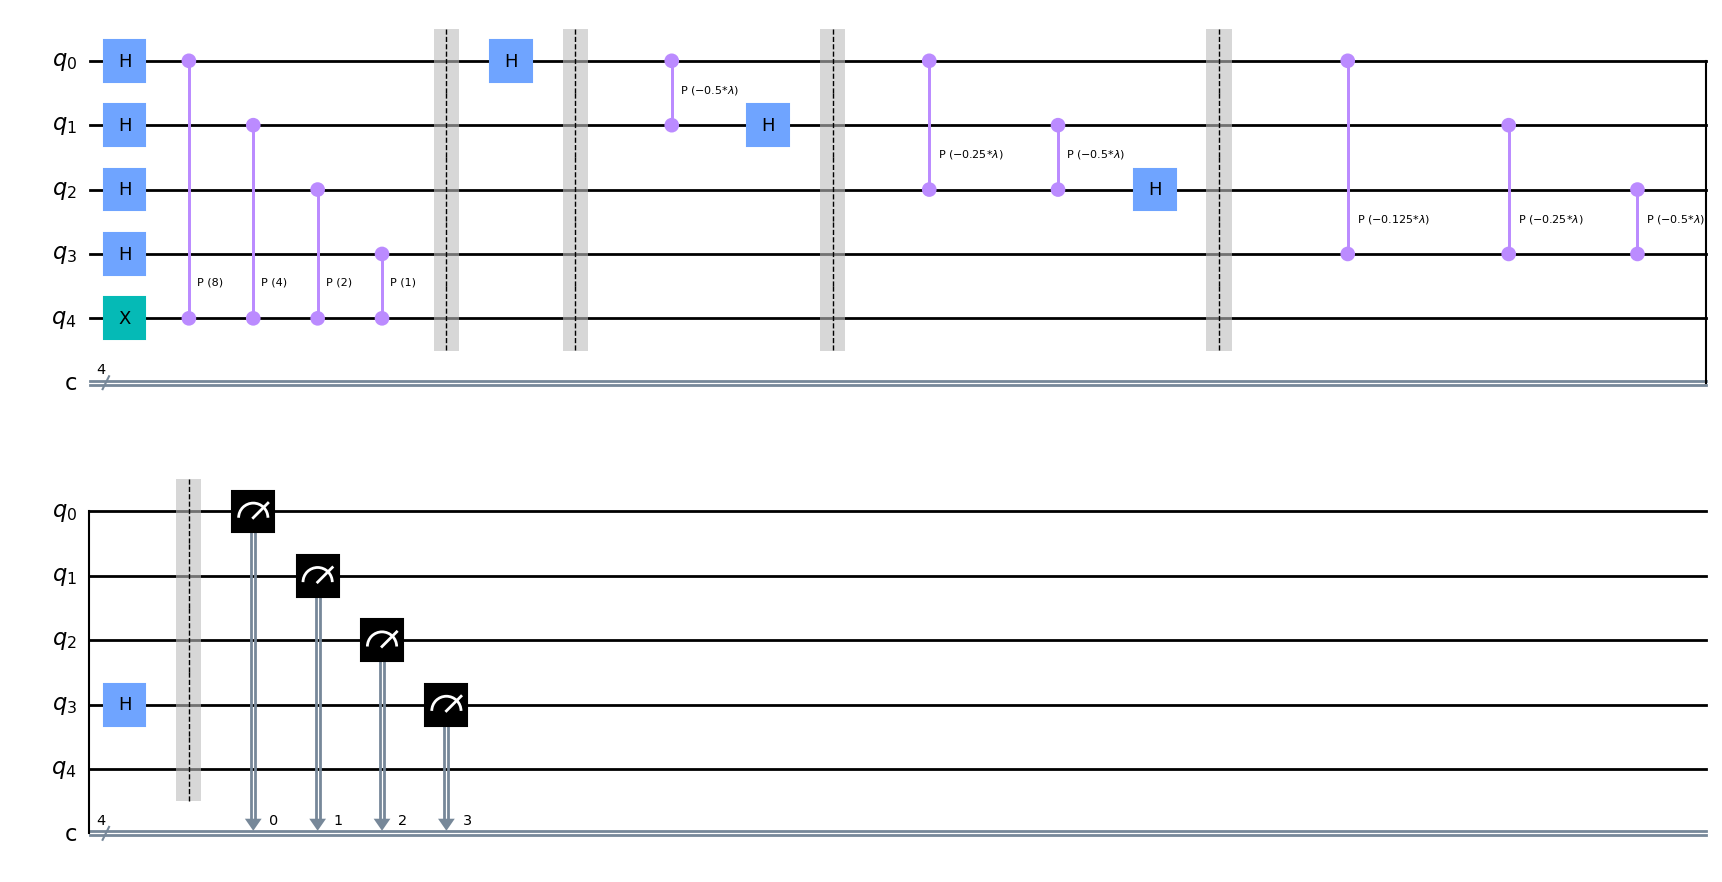

In [7]:
from qiskit.circuit import Parameter
qc = qpe_program(4, Parameter('$\lambda$'))
qc.draw('mpl')

Runs the estimation for an increasing number of qubits. Errors should decrease.

In [9]:
first_guess = 2
second_guess = 4
n_shots = 200
max_iter = 200

sampler = Sampler(options={"shots": n_shots})

for n_qubits in range(7, 20):
    qc_in, qc_out = estimate_pi(n_qubits, first_guess, second_guess, n_shots, sampler, max_iter)
    print('Quantum circuit input:  '+str(qc_in))
    print('Quantum circuit output: '+str(qc_out)+'\n')
    

    

using  7  qubits, converged after  2  iterations
Quantum circuit input:  3.2
Quantum circuit output: 3.2

using  8  qubits, converged after  2  iterations
Quantum circuit input:  3.1219512195121952
Quantum circuit output: 3.1219512195121952

using  9  qubits, converged after  16  iterations
Quantum circuit input:  3.1604938271604937
Quantum circuit output: 3.1604938271604937

using  10  qubits, converged after  2  iterations
Quantum circuit input:  3.1411042944785277
Quantum circuit output: 3.1411042944785277

using  11  qubits, converged after  2  iterations
Quantum circuit input:  3.1411042944785277
Quantum circuit output: 3.1411042944785277

using  12  qubits, converged after  2  iterations
Quantum circuit input:  3.1411042944785277
Quantum circuit output: 3.1411042944785277

using  13  qubits, converged after  2  iterations
Quantum circuit input:  3.1411042944785277
Quantum circuit output: 3.1411042944785277

using  14  qubits, converged after  2  iterations
Quantum circuit input: 